![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

#Equipo 33

*   Oscar Camilo Alvarez Torres
*   Guillermo Ariza
*   Ronaldo Ballesteros Salguero
*   Camila Lenis

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [5]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,10495.0,14538.403716,3922.420961,5002.0,11999.0,15000.0,16999.0,32444.0
Year,10495.0,2013.553883,3.116585,1998.0,2012.0,2014.0,2016.0,2018.0
Mileage,10495.0,52509.430395,36791.736601,5.0,26461.0,41680.0,71355.5,232658.0


In [7]:
data['M_Camry'] = pd.factorize(data.M_Camry)[0]
data['M_Camry4dr'] = pd.factorize(data.M_Camry4dr)[0]
data['M_CamryBase'] = pd.factorize(data.M_CamryBase)[0]
data['M_CamryL'] = pd.factorize(data.M_CamryL)[0]
data['M_CamryLE'] = pd.factorize(data.M_CamryLE)[0]
data['M_CamrySE'] = pd.factorize(data.M_CamrySE)[0]
data['M_CamryXLE'] = pd.factorize(data.M_CamryXLE)[0]
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)
X.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,2014,6480,0,0,0,0,0,0,0
11,2014,39972,0,0,0,1,1,0,0
167,2016,18989,0,0,0,1,0,1,0
225,2014,51330,0,0,0,0,0,0,0
270,2007,116065,0,1,0,1,0,0,0


In [8]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [42]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Se definen los parámetros y criterios de parada
max_depth = None
num_pct = 10
min_gain = 0.001
max_features = None

# función Gini
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# función de impureza de Gini
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# función para encontrar la mejor división
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]
    return best_split

# función para hacer crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    j, split, gain = best_split(X, y, num_pct)
    y_pred = int(y.mean() >= 0.5)
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

# función tree_grow aplicada al conjunto de entrenamiento (se utiliza una profundidad máxima de 3)
tree = tree_grow(X_train, y_train, level=0, min_gain=min_gain, max_depth=3, num_pct=num_pct)

# Definición de la función para hacer predicciones usando el árbol creado
def tree_predict(X, tree):
    predicted = np.ones(X.shape[0])
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
    return predicted

# Ejecución de función tree_predict en el conjunto de prueba
y_pred = tree_predict(X_test, tree)

# Cálculo de RMSE y MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 15113.767253661932
MAE: 14598.966224018475


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [43]:
# Configuración del modelo Bagging
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10  # Número de árboles
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_B)]
models = [DecisionTreeRegressor(max_depth=None, random_state=123 + i) for i in range(n_B)]
y_preds = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenar cada árbol y recoger las predicciones
for i, sample in enumerate(samples):
    X_train_bs = X_train.iloc[sample]
    y_train_bs = y_train.iloc[sample]
    models[i].fit(X_train_bs, y_train_bs)
    y_preds.iloc[:, i] = models[i].predict(X_test)

# Calcular el error RMSE para cada árbol
errors = [np.sqrt(mean_squared_error(y_test, y_preds.iloc[:, i])) for i in range(n_B)]
print("Error RMSE de cada árbol:", errors)

# Calcular el error RMSE del ensamblaje
y_pred_final = y_preds.mean(axis=1)
error_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_final))
print("Error RMSE del ensamblaje:", error_ensemble)

Error RMSE de cada árbol: [2146.0273288250455, 2113.477149810103, 2122.825083832615, 2094.105164088424, 2169.5232943483174, 2106.346181723392, 2140.288987729451, 2188.192810449038, 2137.926119080735, 2133.036378595478]
Error RMSE del ensamblaje: 1799.1353189966887


## **Análisis de Resultados**
**Errores RMSE de Cada Árbol:** Los errores RMSE individuales para cada uno de los 10 árboles varían entre 2094 y 2188. Estos valores muestran que, aunque cada árbol tiene un rendimiento razonable, hay cierta variabilidad entre ellos, lo cual es esperado en el Bagging debido al muestreo con reemplazo (bootstrap).

**Error RMSE del Ensamblaje:** El error RMSE del modelo de ensamblaje es 1799.14, que es notablemente menor que los errores de los árboles individuales. Esto demuestra el beneficio principal del Bagging: al combinar múltiples modelos que pueden tener sobreajustes o errores en diferentes partes del espacio de datos, el ensamble puede generalizar mejor y reducir el error total.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [45]:
# Calculamos log(n_features) para el parámetro max_features
n_features = X_train.shape[1]
max_features = int(np.log(n_features))

# Configuración e inicialización del BaggingRegressor con 10 árboles
bagreg = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(),
    n_estimators=500,
    bootstrap=True,
    max_features=max_features,  # Establecer max_features a log(n_features)
    random_state=1
)

# Entrenamiento del modelo con el conjunto de entrenamiento
bagreg.fit(X_train, y_train)

# Predicción sobre el conjunto de prueba
y_pred = bagreg.predict(X_test)

# Cálculo del error RMSE del modelo
error_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"El error RMSE del modelo Bagging es: {error_rmse}")

El error RMSE del modelo Bagging es: 2591.1421447895973


## **Análisis de Resultados**

**Error RMSE de $2591.00:** Este valor sugiere un rendimiento moderado, lo que indica que las predicciones están razonablemente cerca de los valores reales, considerando la variabilidad típica en los precios de los vehículos.


### **Factores que Pueden Influenciar estos Resultados**

**Diversidad del Modelo:** Usar max_features=log(n_features) busca aumentar la diversidad entre los árboles, lo que normalmente ayuda, pero si limita demasiado las características utilizadas, podría reducir la eficacia del modelo.

**Datos Atípicos y Distribución:** La presencia de datos atípicos o una distribución desequilibrada de los precios podría afectar significativamente el RMSE.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [13]:
reg = RandomForestRegressor(random_state=42)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_rf = np.sqrt(mse_rf)

print("RMSE Random Forest:", rmse_rf)

RMSE Random Forest: 1765.2118433899484


In [14]:
# Impresión de desempeño del modelo usando la función cross_val_score
pd.Series(cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')).describe()

count      10.000000
mean    -1304.134762
std        52.707927
min     -1377.003943
25%     -1356.724122
50%     -1293.704071
75%     -1260.343212
max     -1242.145716
dtype: float64

## **Análisis de Resultados**

Se utiliza la metrica de MAE (Mean Absolute Error) para comparar el desempeño del modelo usando Cross Validation. Esta metrica nos permite ver que tan cerca estan nuestars predicciones del valor real. Se utiliza el valor negativo de MAE ya que al usar cross_val_score con scikit-learn para evaluar modelos de regresión, la convención es que las métricas de puntuación más altas son mejores, por lo tanto para mantener la logica se scikit-learn se evalua el valor negativo de esta forma un valor alto (cercano a 0, teniendo en cuenta el valor negativo) sera mejor.

**El modelo nos genera un MSE en promedio de 1765.21**, lo que indica que en promedio nuestras predicciones estan desfazadas 1765 del valor real

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Text(0, 0.5, 'neg_mae')

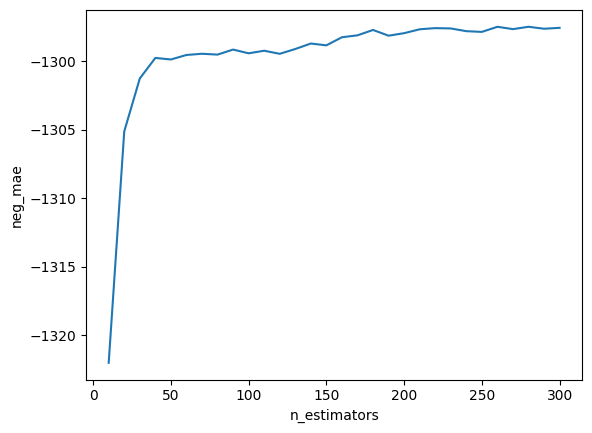

In [48]:
# Calibración de n_estimators
estimator_range = range(10, 310, 10)
mae_scores = []
for estimator in estimator_range:
    clf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    mae_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, mae_scores)
plt.xlabel('n_estimators')
plt.ylabel('neg_mae')

Text(0, 0.5, 'neg_mae')

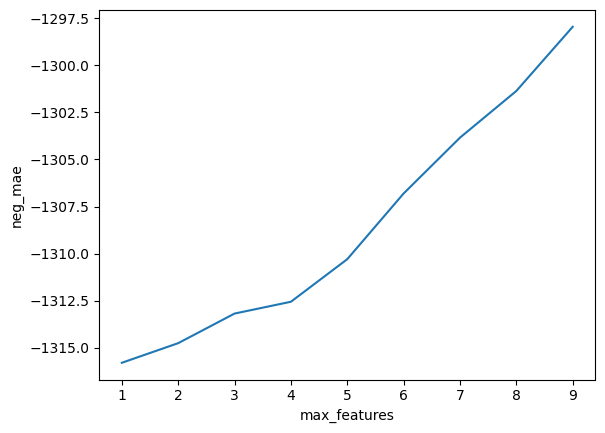

In [49]:
# Calibracióm max_features
feature_range = range(1, X_train.shape[1]+1)

mae_scores = []

for feature in feature_range:
    clf = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    mae_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean())

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, mae_scores)
plt.xlabel('max_features')
plt.ylabel('neg_mae')

Se puede observar de las graficas que con n_estimators gual a 50 se logra una mejora significatica en el MSE, ya despues de este valor el incremento del MSE no es tan significativo. Aunque podemos ver con con alrededor de 250 arboles tenemos un valor de MAE tambien bueno, tener tantos arboles podria generar un sobreajuste haciendo que nuestro modelo no tenga una capacidad de prediccion buena sobre otro set de datos diferente al de entranamiento.

En relacion al parametro de max_features, podemos evidenciar que con 9 variables se tiene el mejor desempeño, con un MAE de 1297. Pero a pesar de que esto sea verdad le estaríamos quitando el foco del random forest que es tener aleatoriedad en el número de variables a usar.

In [54]:
#Implementación de un Random Forest con los mejores parámetros
random_forest = RandomForestRegressor(n_estimators=50, max_features=9, random_state=1, n_jobs=-1)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)
mse_random_forest = mean_squared_error(y_test, y_pred)
# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_random_forest = np.sqrt(mse_random_forest)

print("RMSE sobre datos de prueba:", rmse_random_forest)

RMSE sobre datos de prueba: 1757.1326718029936


Si bien el modelo mejoró su desempeño, la mejora no es significativa.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [9]:
reg = XGBRegressor(random_state=1, n_estimators=100)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse_xgboost = mean_squared_error(y_test, y_pred)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_xgboost_without_tunning = np.sqrt(mse_xgboost)

print("RMSE XGBoost:", rmse_xgboost_without_tunning)

RMSE XGBoost: 1605.2355199928948


## **Análisis de Resultados**

El modelo de XGBoost sin calibrar nos da un RMSE de 1605, que es menor al RMSE del modelo Random Forest sin calibrar.

Esto significa que, en promedio, las predicciones de XGBoost sin calibrar están más cerca de los valores reales que las predicciones de Random Forest sin calibrar, incluso que el random Forest calibrado.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [10]:
from sklearn.model_selection import GridSearchCV

gamma_range = [0.01, 0.1, 1.0, 10.0]
lr_range = [0.01, 0.05, 0.1, 0.2, 0.3]
colsample_range = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


grid_search_params = {
    'gamma': gamma_range,
    'learning_rate': lr_range,
    'colsample_bytree': colsample_range
}

model = XGBRegressor(objective='reg:squarederror', random_state=1, n_jobs=-1)

grid = GridSearchCV(estimator=model, param_grid=grid_search_params, scoring='neg_mean_squared_error', cv=4, verbose=1)
grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
{'colsample_bytree': 0.7, 'gamma': 0.01, 'learning_rate': 0.05}


Ya encontramos los valores óptimos de los parámetros. Ahora vamos a ver cómo se comporta cad auno de ellos por separado

Text(0.5, 1.0, 'Desempeño del modelo vs gamma')

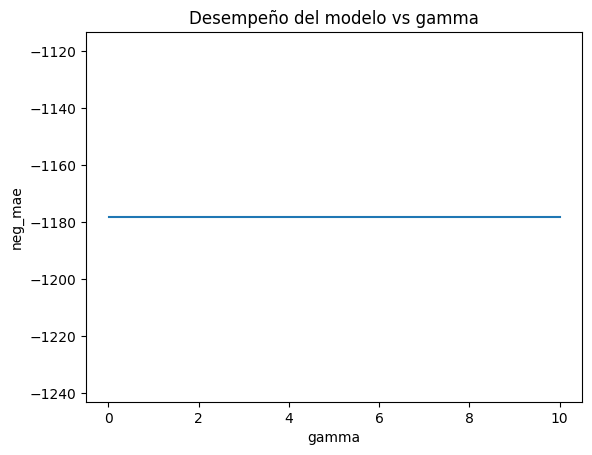

In [15]:
# Calibración de gamma
from sklearn.model_selection import cross_val_score
gamma_values = [0.01, 0.1, 1.0, 10.0]
mae_scores_gamma = []
for gamma in gamma_values:
    clf = XGBRegressor(gamma=gamma, random_state=1, n_jobs=-1)
    mae_scores_gamma.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean())

# Gráfica del desempeño del modelo vs el valor de gamma
plt.plot(gamma_values, mae_scores_gamma)
plt.xlabel('gamma')
plt.ylabel('neg_mae')
plt.title('Desempeño del modelo vs gamma')

Text(0.5, 1.0, 'Desempeño del modelo vs learning rate')

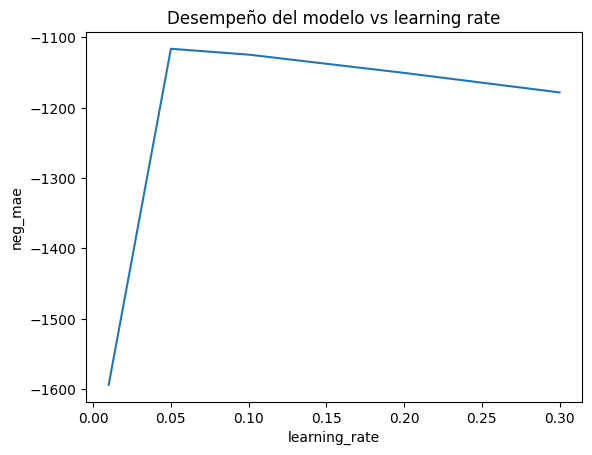

In [16]:
# Calibración de learning rate
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
mae_scores_lr = []
for lr in learning_rates:
    clf = XGBRegressor(learning_rate=lr, random_state=1, n_jobs=-1)
    mae_scores_lr.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean())

# Gráfica del desempeño del modelo vs learning rate
plt.figure()
plt.plot(learning_rates, mae_scores_lr)
plt.xlabel('learning_rate')
plt.ylabel('neg_mae')
plt.title('Desempeño del modelo vs learning rate')

Text(0.5, 1.0, 'Desempeño del modelo vs colsample_bytree')

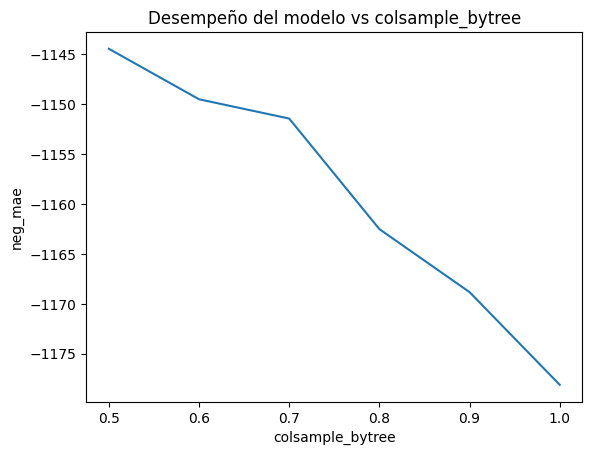

In [17]:
# Calibración de colsample_bytree
colsample_bytree_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mae_scores_colsample = []
for colsample in colsample_bytree_values:
    clf = XGBRegressor(colsample_bytree=colsample, random_state=1, n_jobs=-1)
    mae_scores_colsample.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean())

# Gráfica del desempeño del modelo vs colsample_bytree
plt.figure()
plt.plot(colsample_bytree_values, mae_scores_colsample)
plt.xlabel('colsample_bytree')
plt.ylabel('neg_mae')
plt.title('Desempeño del modelo vs colsample_bytree')

In [18]:
reg = XGBRegressor(colsample_bytree=0.7, learning_rate=0.05, gamma_values=0.01)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse_xgboost = mean_squared_error(y_test, y_pred)

# Calcular el Error Cuadrático Medio de la Raíz (RMSE)
rmse_xgboost = np.sqrt(mse_xgboost)

print("RMSE XGBoost:", rmse_xgboost)

RMSE XGBoost: 1546.2337440494284


## **Análisis de Resultados**

Al calibrar el modelo de XGBoost nos da un RMSE de 1546,2, que es menor al RMSE del modelo modelo sin calibrar. Lo que sugiere que hemos encontrado unos parámetros más óptimos para el modelo

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

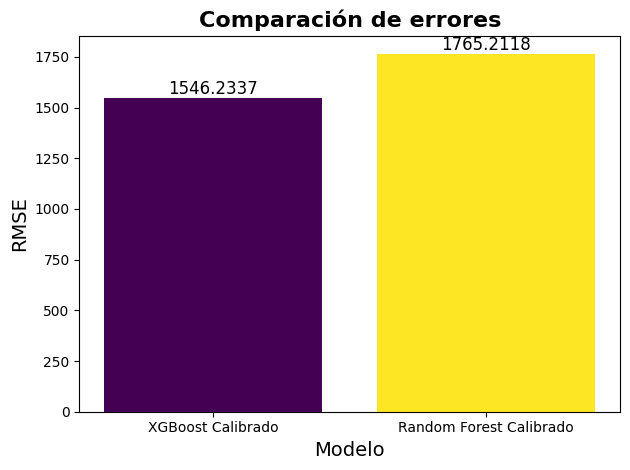

In [19]:
# Errores
models = ['Random Forest Calibrado', 'XGBoost Calibrado']
errors = [rmse_rf, rmse_xgboost]

# Sorting
sorted_indices = np.argsort(errors)
sorted_models = [models[idx] for idx in sorted_indices]
sorted_errors = [errors[idx] for idx in sorted_indices]

# Colores
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_models)))

# Crear el plot
fig, ax = plt.subplots()
ax.set_title("Comparación de errores", fontsize=16, fontweight='bold')
ax.set_xlabel("Modelo", fontsize=14)
ax.set_ylabel("RMSE", fontsize=14)
ax.bar(sorted_models, sorted_errors, color=colors)

# Etiquetas de datos
for i, v in enumerate(sorted_errors):
    ax.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom', fontsize=12, color='black')

# Layout
plt.tight_layout()

# Mostrar el plot
plt.show()

## **Conclusiones**

- El modelo de XGBoost para este caso tiene un mejor desempeño que el modelo random Forest

**Ventajas del modelo XGBoost:**
- Mejor manejo de datos complejos: XGBoost es capaz de manejar mejor conjuntos de datos con características no lineales e interacciones complejas entre ellas.
- Regularización incorporada: XGBoost cuenta con mecanismos de regularización integrados que ayudan a prevenir el sobreajuste y mejorar la generalización del modelo.
- Admite valores nulos: No se ve tan afectado por los valores nulos en la base de datos

**Desventajas del modelo Random Forest:**
- Sobreajuste rápido: Esto significa que el modelo aprende los detalles específicos del conjunto de entrenamiento pero no generaliza bien a nuevos datos no vistos.
- Falta de interpretabilidad: Esto se debe a que son conjuntos de muchos árboles de decisión individuales, y puede ser difícil entender cómo un árbol de decisión específico contribuye a la predicción general.
- Sensibilidad a valores atípicos: Esto se debe a que los árboles de decisión individuales en el bosque pueden dar un peso excesivo a estos puntos.

Cabe resaltar que esto no es una ley universal y no significa que en todos los casos vayamos a encontrar que el XGBoost es mejor que el Random Forest. Debemos tener el cuenta el contexto y la naturaleza de las variables a utilizar, y el problema que estamos resolviendo.